In [178]:
import numpy as np
from scipy.linalg import expm
from qiskit import*

# Hamiltonian

$$ H = -J\sum^{L-1}_{j=1}(X_{j}X_{j+1}+Y_{j}Y_{j+1}+Z_{j}Z_{j+1})  = -J\sum_{\rm odd} H -J \sum_{\rm even} H $$
Time evolution
$$ U = e^{-iH\delta} \approx e^{-iH_{\rm odd}\delta} e^{-iH_{\rm even}\delta} = (e^{-iH_{12}\delta} e^{-iH_{34}\delta}\cdots)(e^{-iH_{23}\delta} e^{-iH_{45}\delta}\cdots)$$


# Implementing the gate: $\exp(-iJ(Z_{1} \otimes Z_{2}) \delta)$
This can be done using the followng circuit (Source: https://arxiv.org/abs/1001.3855)

In [180]:
# Number of qubits in the system.
L = 4

In [181]:
def zz_circuit(qubit_0,qubit_1,delta):
    qc_zz = QuantumCircuit(L)
    qc_zz.cx(qubit_0,qubit_1)
    qc_zz.rz(2*delta,qubit_1)
    qc_zz.cx(qubit_0,qubit_1)
    return qc_zz#.draw("mpl",scale=1.5)

# Implementing the gate: $\exp(-iJ(X_{1} \otimes X_{2}) \delta)$
The following identity is used (Source: https://learn.microsoft.com/en-us/azure/quantum/user-guide/libraries/chemistry/concepts/algorithms)
$$\exp(-iJ(X_{1} \otimes X_{2}) \delta) = (H \otimes H) \exp(-i(Z \otimes Z)\delta) (H \otimes H)$$

In [182]:
def xx_circuit(qubit_0,qubit_1,delta):
    qc_xx = QuantumCircuit(L)
    qc_xx.h(qubit_0)
    qc_xx.h(qubit_1)
    qc_xx.cx(qubit_0,qubit_1)
    qc_xx.rz(2*delta,qubit_1)
    qc_xx.cx(qubit_0,qubit_1)
    qc_xx.h(qubit_0)
    qc_xx.h(qubit_1)
    return qc_xx#.draw("mpl",scale=1.5)

# Implementing the gate: $\exp(-iJ(Y_{1} \otimes Y_{2}) \delta)$

In [183]:
def yy_circuit(qubit_0,qubit_1,delta):
    qc_yy = QuantumCircuit(L)
    qc_yy.sdg(qubit_0)
    qc_yy.sdg(qubit_1)
    qc_yy.h(qubit_0)
    qc_yy.h(qubit_1)
    qc_yy.cx(qubit_0,qubit_1)
    qc_yy.rz(2*delta,qubit_1)
    qc_yy.cx(qubit_0,qubit_1)
    qc_yy.h(qubit_0)
    qc_yy.h(qubit_1)
    qc_yy.s(qubit_0)
    qc_yy.s(qubit_1)
    return qc_yy#.draw("mpl",scale=1.5)

# Circuit for one time step

In [207]:
r"""
The following function constructs the quantum circuit for one time step for the complete Hamiltonian.
"""
def one_time_step(time_step):
    qc = QuantumCircuit(L)
    # Odd bonds are constructed.
    for i in range(0,L-1,2):
        qc = qc.compose(xx_circuit(i,i+1,time_step))
    
    qc.barrier()
    for i in range(0,L-1,2):
        qc = qc.compose(yy_circuit(i,i+1,time_step))   
        
    qc.barrier()
    for i in range(0,L-1,2):
        qc = qc.compose(zz_circuit(i,i+1,time_step))  
        
    qc.barrier()
    # Even bonds are constructed.
    for i in range(1,L-1,2):
        qc = qc.compose(xx_circuit(i,i+1,time_step))  
    
    qc.barrier()
    for i in range(1,L-1,2):
        qc = qc.compose(yy_circuit(i,i+1,time_step)) 
        
    qc.barrier()
    for i in range(1,L-1,2):
        qc = qc.compose(zz_circuit(i,i+1,time_step))    
    return qc#.draw("mpl",scale=1.5)
one_time_step(1.e-5)

In [206]:
def time_evolution_circuit(time_step,duration):
    steps = int(duration/time_step)
    qc = QuantumCircuit(L)
    for i in range(steps):
        qc = qc.compose(one_time_step(time_step))
    return qc

# Transpile circuit with basis gates

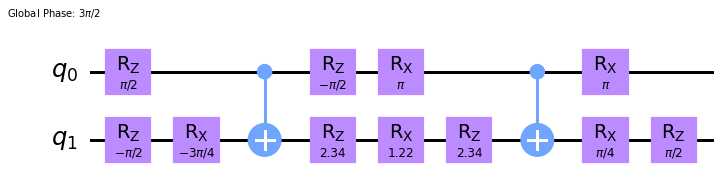

In [143]:
from qiskit import QuantumCircuit
from qiskit.extensions import UnitaryGate

delta = np.pi/5
matrix = expm(-1j*np.kron(Pauli_z,Pauli_z)*delta)
gate = UnitaryGate(matrix)

circuit = QuantumCircuit(2)
circuit.append(gate, [0, 1])
transpiled_circuit = transpile(circuit,basis_gates = ['rx','cx','rz'],optimization_level=1)
transpiled_circuit.draw("mpl",scale=1.5)